# Points of Interest Scoring
This notebook handles the loading of datasets and runs a scoring algorithm on a grid array

In [90]:
import math
import numpy as np
from pathlib import Path
from get_bounds import *
from misc_utility import *
from plotting_utility import *
import statistics

### Dataset Retrieval and Preprocessing

In [91]:
def getRestaurants(city):
    df = pd.read_csv('../res/datasets/csv/' + city + '/restaurant.csv', sep = ',', header=None, names=['lat', 'long', 'name'])
    df['type'] = 'restaurant'
    return df

In [92]:
def getCommunityCentres(city):
    df = pd.read_csv('../res/datasets/csv/' + city + '/community_centre.csv', sep = ',', header=None, names=['lat', 'long', 'name'])
    df['type'] = 'community_centre'
    return df

In [93]:
def getFoodCourts(city):
    df = pd.read_csv('../res/datasets/csv/' + city + '/food_court.csv', sep = ',', header=None, names=['lat', 'long', 'name'])
    df['type'] = 'food_court'
    return df

In [94]:
def getLibraries(city):
    df = pd.read_csv('../res/datasets/csv/' + city + '/library.csv', sep = ',', header=None, names=['lat', 'long', 'name'])
    df['type'] = 'library'
    return df

In [95]:
def getUniversities(city):
    df = pd.read_csv('../res/datasets/csv/' + city + '/university.csv', sep = ',', header=None, names=['lat', 'long', 'name'])
    df['type'] = 'university'
    return df

### Scoring Parameters

In [96]:
STD_DEV = 0.9
PT_DENSITY = 100
SCORE_MIN_THRESHOLD = 0.01

### Scoring Functions

In [97]:
def score(latStation, longStation, latOrigin, longOrigin, stdDev):

    stationCor = (latStation, longStation)

    totalScore = 0

    for Lat, Long in zip(latOrigin, longOrigin):
        origin = (Lat, Long)
        r = getDistance(origin, stationCor)
        # this score function simply uses the traditional gaussian distribution formula,
        # except it extracts all the common parts to be multiplied last for efficiency.
        score =  math.exp(-0.5*((r**2) / (stdDev**2)))
        totalScore += score

    #adjustFactor = 210 * 0.9974
    #totalScore = (totalScorePre/adjustFactor)*100

    # Multiply common part in gaussian distribution formula
    totalScore *= (1/(stdDev * math.sqrt(2 * math.pi)))

    return totalScore

In [98]:
def scoreAvg(latStation, longStation, latOrigin, longOrigin, stdDev):

    stationCor = (latStation, longStation)

    scores = []

    for Lat, Long in zip(latOrigin, longOrigin):
        origin = (Lat, Long)
        r = getDistance(origin, stationCor)
        # this score function simply uses the traditional gaussian distribution formula,
        # except it extracts all the common parts to be multiplied last for efficiency.
        score = (1/(stdDev * math.sqrt(2 * math.pi))) * math.exp(-0.5*((r**2) / (stdDev**2)))
        scores.append(score)

    #adjustFactor = 210 * 0.9974
    #totalScore = (totalScorePre/adjustFactor)*100

    # Multiply common part in gaussian distribution formula
    return statistics.mean(scores) if len(scores) > 0 else 0.0

In [99]:
def generateGridScores(poi, std_dev, upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    gridPoints = pd.DataFrame(columns = ['lat', 'long', 'score'])
    latStep = round((upperLatBound-bottomLatBound)/(PT_DENSITY-1), 4)
    longStep = round((rightLongBound-leftLongBound)/(PT_DENSITY-1), 4)
    quarterPoint = bottomLatBound+latStep*PT_DENSITY/4
    midPoint = bottomLatBound+latStep*PT_DENSITY/2
    tfPoint = bottomLatBound+latStep*3*PT_DENSITY/4

    for lat in np.linspace(bottomLatBound, upperLatBound, num=PT_DENSITY):
        if (abs(lat - quarterPoint) <= 0.005):
            print("25% complete")
        if (abs(lat - midPoint) <= 0.005):
            print("50% complete")
        if (abs(lat - tfPoint) <= 0.005):
            print("75% complete")
        for long in np.linspace(leftLongBound, rightLongBound, num=PT_DENSITY):
            pointScore = score(lat, long, poi['lat'], poi['long'], std_dev);

            pointScore = pointScore if pointScore > SCORE_MIN_THRESHOLD else 0.0;

            pointScoreDict = {'lat' : [lat], 'long' : [long], 'score' : [pointScore]};
            pointScoreDf = pd.DataFrame(data=pointScoreDict)
            gridPoints = pd.concat([gridPoints, pointScoreDf], ignore_index = True)

    return gridPoints

### Score

In [100]:
def scoreGridPoints(city, std_dev):
    restaurants = getRestaurants(city)
    community_centres = getCommunityCentres(city)
    food_courts = getFoodCourts(city)
    libraries = getLibraries(city)
    universities = getUniversities(city)

    pointsOfInterest = pd.concat([restaurants, community_centres, food_courts, libraries, universities])
    [upperLatBound, bottomLatBound, leftLongBound, rightLongBound] = getBounds(pointsOfInterest['lat'], pointsOfInterest['long'], 4)
    return generateGridScores(pointsOfInterest, std_dev, upperLatBound, bottomLatBound, leftLongBound, rightLongBound)

In [101]:
#YYZ_GridPoints = scoreGridPoints("toronto", STD_DEV)
#YVR_GridPoints = scoreGridPoints("vancouver", STD_DEV)
#YYC_GridPoints = scoreGridPoints("calgary")
#YGK_GridPoints = scoreGridPoints("kingston", STD_DEV)
BCN_GridPoints = scoreGridPoints("barcelona", STD_DEV)
BER_GridPoints = scoreGridPoints("berlin", STD_DEV)

25% complete
50% complete
50% complete
75% complete
75% complete
25% complete
25% complete
25% complete
50% complete
50% complete
50% complete
75% complete
75% complete
75% complete


### Export

In [102]:
def exportScoresToCsv(gridPoints, name):
    filepath = Path('../res/grid_points/' + name + '.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    gridPoints.to_csv(filepath)

In [103]:
def exportDataFrameToCoordsTxt(dataFrame, name):
    with open(name + '_coords.txt', 'w') as f:
        for lat in dataFrame['lat']:
            f.write(str(lat))
            f.write(',')
    f.write("\n")
    for long in dataFrame['long']:
        f.write(str(long))
        f.write(',')

In [104]:
#exportScoresToCsv(YYZ_GridPoints, 'yyz_grid_points')
#exportScoresToCsv(YVR_GridPoints, 'yvr_grid_points')
#exportScoresToCsv(YYC_GridPoints, 'yyc_grid_points')
#exportScoresToCsv(YGK_GridPoints, 'ygk_grid_points_' + str(STD_DEV))
exportScoresToCsv(BCN_GridPoints, 'bcn_grid_points_' + str(STD_DEV))
exportScoresToCsv(BER_GridPoints, 'ber_grid_points_' + str(STD_DEV))

In [ ]:
def bulkRun(STD_DEVS):
    for sd in STD_DEVS:
        YYZ_GridPoints = scoreGridPoints("toronto", sd)
        exportScoresToCsv(YYZ_GridPoints, 'yyz_grid_points_' + str(sd))

        YVR_GridPoints = scoreGridPoints("vancouver", sd)
        exportScoresToCsv(YVR_GridPoints, 'yvr_grid_points_' + str(sd))

        YYC_GridPoints = scoreGridPoints("calgary", sd)
        exportScoresToCsv(YYC_GridPoints, 'yyc_grid_points_' + str(sd))

<Axes3DSubplot:>

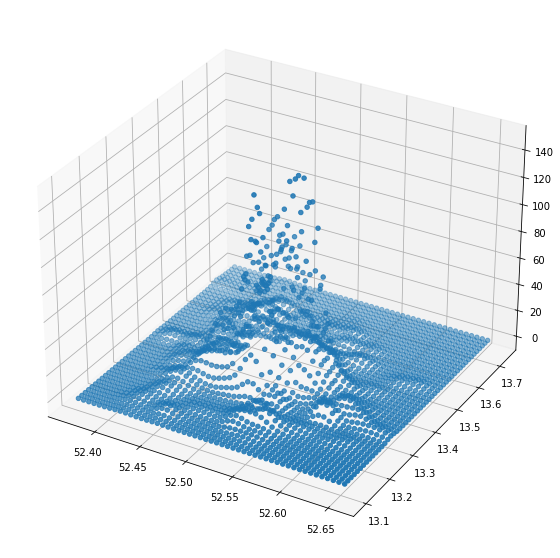

In [89]:
plotGridPoints3D(BER_GridPoints)

In [ ]:
#bulkRun([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97])